# Simulación del eclipse de Eddington

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import get_sun, EarthLocation, AltAz, get_moon, SkyCoord
from astropy.time import Time
from astropy import units as u
from astroquery.gaia import Gaia
from astropy.utils import iers
iers.conf.auto_download = True
iers.conf.auto_max_age = None  # evita que caduquen los datos descargados
from geopy.geocoders import Nominatim

La latitud y longitud de Santo António son: 1.6367, 7.4178
Radio angular Sol (grados): 0.263086
Radio angular Luna (grados): 0.277080
Posición del Sol (grados): 299.054602,44.421020
Posición de la luna (grados): 299.049429,44.424944
1


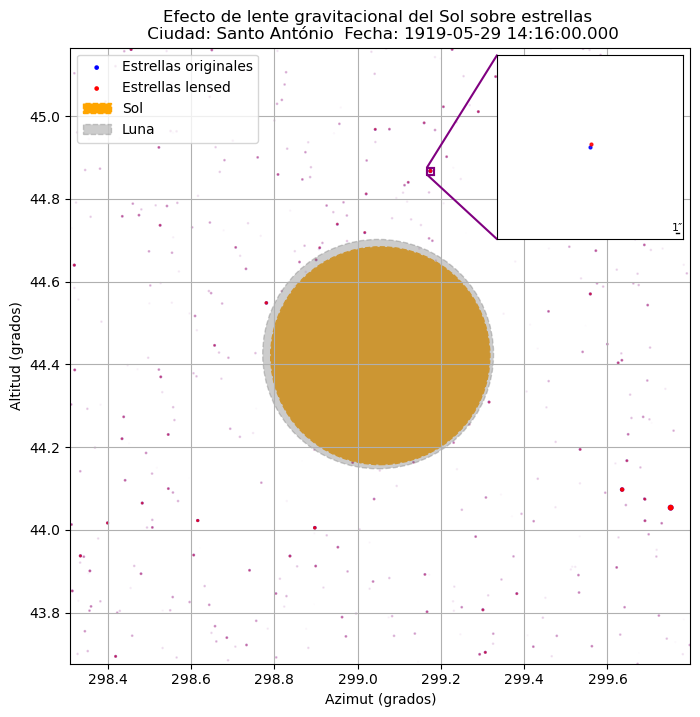

In [7]:

# Crear el geolocalizador
geolocator = Nominatim(user_agent="astro_locator")

def obtener_lat_lon(ciudad):
    location = geolocator.geocode(ciudad)
    if location:
        return location.latitude, location.longitude
    else:
        return 43.3618625, -5.8483581

# Ejemplo de uso

#ciudad = "Oviedo"
#latitud, longitud = 43.3618625, -5.8483581 # Oviedo 
#time = Time('2026-08-12 18:28:00') #Oviedo
ciudad = "Santo António"
latitud, longitud = 1.6367, 7.4178 # Santo António
time = Time('1919-05-29 14:16:00') #Santo António

#obtener_lat_lon(ciudad)
print(f"La latitud y longitud de {ciudad} son: {latitud}, {longitud}")


# Datos de la ciudad y hora
latitude = latitud  # en grados
longitude = longitud  # en grados
altitude = 45  # en metros


# Crear la ubicación de Oviedo
city = EarthLocation.from_geodetic(lon=longitude * u.deg, lat=latitude * u.deg, height=altitude * u.m)

# Obtención de la posición del Sol y la Luna
sun = get_sun(time)
moon = get_moon(time)

# Conversión de coordenadas al sistema AltAz (altitud y acimut)
altaz_frame = AltAz(obstime=time, location=city)
sun_altaz = sun.transform_to(altaz_frame)
moon_altaz = moon.transform_to(altaz_frame)

# Usar las coordenadas del Sol como centro de la búsqueda
center_coord = sun  # Coordenada del Sol

# Radio del Sol y la Luna en kilómetros
sun_radius_km = 696340  # Radio del Sol en km
moon_radius_km = 1737   # Radio de la Luna en km

# Obtener las distancias de la Tierra al Sol y la Luna desde astropy
sun_distance = sun.distance  # Distancia del Sol a la Tierra en AU
moon_distance = moon.distance  # Distancia de la Luna a la Tierra en AU

# Convertir las distancias a kilómetros
sun_distance_km = sun_distance.to(u.km).value  # Distancia del Sol en km
moon_distance_km = moon_distance.to(u.km).value  # Distancia de la Luna en km

# Calcular el radio angular en grados para el Sol y la Luna
sun_radius_deg = (sun_radius_km / sun_distance_km) * (180 / np.pi)
moon_radius_deg = (moon_radius_km / moon_distance_km) * (180 / np.pi)

print(f"Radio angular Sol (grados): {sun_radius_deg:.6f}")
print(f"Radio angular Luna (grados): {moon_radius_deg:.6f}")
print(f"Posición del Sol (grados): {sun_altaz.az.deg:.6f},{sun_altaz.alt.deg:.6f}")
print(f"Posición de la luna (grados): {moon_altaz.az.deg:.6f},{moon_altaz.alt.deg:.6f}")

# Establecer el radio de búsqueda para la consulta Gaia (por ejemplo 2 veces el radio del sol)
radius = 4 * sun_radius_deg  # Esto es float, no usar .value aquí

# Consulta a Gaia para obtener las 1000 estrellas más brillantes alrededor del Sol (en ICRS)
gaia_query = f"""
SELECT TOP 1000 source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS', ra, dec),
               CIRCLE('ICRS', {center_coord.ra.deg}, {center_coord.dec.deg}, {radius})) = 1
AND phot_g_mean_mag IS NOT NULL
ORDER BY phot_g_mean_mag ASC
"""


job = Gaia.launch_job(gaia_query)
results = job.get_results()

ra = results['ra'].data.astype(float)
dec = results['dec'].data.astype(float)
magnitudes = results['phot_g_mean_mag'].data.astype(float)

star_coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Transformar las coordenadas de las estrellas a AltAz
stars_altaz = star_coords.transform_to(altaz_frame)

# Normalizar la magnitud para ajustar el tamaño y la transparencia
sizes = 100 / (magnitudes - np.min(magnitudes) + 1)
alphas = 1 - (magnitudes - np.min(magnitudes)) / (np.max(magnitudes) - np.min(magnitudes))


from astropy.constants import G, M_sun, c
from astropy import units as u

# Constantes físicas
G_val = G.value  # m^3 / (kg s^2)
M_sun_val = M_sun.value  # kg
c_val = c.value  # m/s


# Posiciones del Sol y estrellas en AltAz (en radianes)
sun_az_rad = sun_altaz.az.rad
sun_alt_rad = sun_altaz.alt.rad

stars_az_rad = stars_altaz.az.rad
stars_alt_rad = stars_altaz.alt.rad

# Calcular la separación angular 'ζ' entre cada estrella y el Sol en radianes
delta_az = stars_az_rad - sun_az_rad
delta_alt = stars_alt_rad - sun_alt_rad
ζ = np.sqrt(delta_az**2 + delta_alt**2)  # distancia angular en radianes

# Evitar división por cero (para estrellas exactamente en la posición del sol)
ζ = np.where(ζ == 0, 1e-10, ζ)

# Distancia Tierra-Sol en metros (usar la ya calculada pero convertida)
sun_distance_m = sun_distance.to(u.m).value

# Calcular la distancia de impacto en metros (ζ * distancia Tierra-Sol)
ζ_m = ζ * sun_distance_m

# Calcular el ángulo de desviación en radianes
alpha = (4 * G_val * M_sun_val) / (c_val**2 * ζ_m)  # en radianes

# Calcular el vector unitario desde el sol a cada estrella (para dirección de desviación)
unit_vec_az = delta_az / ζ
unit_vec_alt = delta_alt / ζ

# Aplicar la desviación a la posición angular de cada estrella
# Para simplificar, desplazamos las estrellas *hacia afuera* respecto al Sol:
stars_az_lensed = stars_az_rad + alpha * unit_vec_az
stars_alt_lensed = stars_alt_rad + alpha * unit_vec_alt

# Convertir de nuevo a grados para graficar
stars_az_lensed_deg = np.degrees(stars_az_lensed)
stars_alt_lensed_deg = np.degrees(stars_alt_lensed)

# Rango deseado en grados

az_center_deg = np.degrees(stars_az_rad[2])
alt_center_deg = np.degrees(stars_alt_rad[2])
#print(len(stars_az_lensed))
#az_center_deg = 181.085
#alt_center_deg = 9.988

az_min, az_max = az_center_deg-30/3600,  az_center_deg+30/3600
alt_min, alt_max =  alt_center_deg-30/3600,  alt_center_deg+30/3600


# Máscara para estrellas lensed
mask_lensed = (
    (stars_az_lensed_deg >= az_min) & (stars_az_lensed_deg <= az_max) &
    (stars_alt_lensed_deg >= alt_min) & (stars_alt_lensed_deg <= alt_max)
)

# Máscara para estrellas originales (no lensed)
mask_original = (
    (np.degrees(stars_az_rad) >= az_min) & (np.degrees(stars_az_rad) <= az_max) &
    (np.degrees(stars_alt_rad) >= alt_min) & (np.degrees(stars_alt_rad) <= alt_max)
)

# Extraer posiciones filtradas
filtered_az_lensed = stars_az_lensed_deg[mask_lensed]
filtered_alt_lensed = stars_alt_lensed_deg[mask_lensed]

print(len(filtered_az_lensed))
filtered_az_original = np.degrees(stars_az_rad)[mask_original]
filtered_alt_original = np.degrees(stars_alt_rad)[mask_original]

filtered_sizes= sizes[mask_original]
filtered_alphas= alphas[mask_original]

#filtered_name= results['source_id'][mask_original]

import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))

# Imagen principal: estrellas originales y lensed en todo el rango que tengas
ax.scatter(np.degrees(stars_az_rad), np.degrees(stars_alt_rad), s=sizes*0.1, color='blue', alpha=alphas, label='Estrellas originales')
ax.scatter(stars_az_lensed_deg, stars_alt_lensed_deg, s=sizes*0.1, color='red', alpha=alphas, label='Estrellas lensed')

# Sol y Luna
#ax.scatter(sun_altaz.az.deg, sun_altaz.alt.deg, c='red', label='Sol', s=100, marker='x')
#ax.scatter(moon_altaz.az.deg, moon_altaz.alt.deg, c='green', label='Luna', s=100, marker='.')

# Añadir circunferencias del Sol y la Luna
sun_circle = plt.Circle((sun_altaz.az.deg, sun_altaz.alt.deg), sun_radius_deg,
                        color='orange', fill=True, alpha=1, linestyle='--', label='Sol')
plt.gca().add_artist(sun_circle)

#sun_schwarzschild_radious = plt.Circle((sun_altaz.az.deg, sun_altaz.alt.deg), 235787*2*G_val*M_sun_val/c_val**2/sun_distance_m*180/np.pi,
#                        color='red', fill=False linestyle='--', label='Schwarzchild radius')
#print(sun_radius_deg/(2*G_val*M_sun_val/c_val**2/sun_distance_m*180/np.pi))

moon_circle = plt.Circle((moon_altaz.az.deg, moon_altaz.alt.deg), moon_radius_deg,
                         color='gray', fill=True, alpha=0.4, linestyle='--', label='Luna')
plt.gca().add_artist(moon_circle)

#plt.gca().add_artist(sun_schwarzschild_radious)
ax.set_xlim(sun_altaz.az.deg-radius/np.sqrt(2), sun_altaz.az.deg+radius/np.sqrt(2))
ax.set_ylim(sun_altaz.alt.deg-radius/np.sqrt(2), sun_altaz.alt.deg+radius/np.sqrt(2))
ax.set_xlabel('Azimut (grados)')
ax.set_ylabel('Altitud (grados)')
ax.set_title(f'Efecto de lente gravitacional del Sol sobre estrellas \n Ciudad: {ciudad}  Fecha: {str(time)}')
ax.legend()
ax.grid(True)

# Dibujar rectángulo en la imagen principal para la zona ampliada
rect = patches.Rectangle((az_min, alt_min), az_max - az_min, alt_max - alt_min,
                         linewidth=1.5, edgecolor='purple', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Crear un zoom (inset) en la figura
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins = inset_axes(ax, width="30%", height="30%", loc='upper right')  # posición y tamaño del zoom

# Plot zoom con los puntos filtrados (usa tus máscaras)
axins.scatter(filtered_az_original, filtered_alt_original, s=filtered_sizes*0.1, color='blue', alpha=filtered_alphas, label='No lensed')
axins.scatter(filtered_az_lensed, filtered_alt_lensed, s=filtered_sizes*0.1, color='red', alpha=filtered_alphas, label='Lensed')

axins.set_xlim(az_min, az_max)
axins.set_ylim(alt_min, alt_max)
axins.set_xticks([])
axins.set_yticks([])
axins.grid(True)

arcsec_in_deg = 1 / 3600  # ≈ 0.00027778

scale_bar_x = az_max - 0.0007  # dentro del recuadro
scale_bar_y = alt_min + 0.0006

axins.plot([scale_bar_x, scale_bar_x + arcsec_in_deg],
           [scale_bar_y, scale_bar_y],
           color='black', linewidth=1)

axins.text(scale_bar_x + arcsec_in_deg / 2,
           scale_bar_y,
           "1″",
           ha='center', va='bottom', fontsize=8)

#axins.set_title('Zoom en región seleccionada', fontsize=10)

# Dibujar líneas que conectan el recuadro con la imagen ampliada
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="purple", lw=1.5)

#plt.show()
plt.savefig(f"../Multimedia/Eclipse_{str(ciudad)}_{str(time)}.png")
